# Qiskit Workshop: Sessions in Qiskit Runtime

In [3]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import *

from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Session

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(name='pinq2')

## Variational Algorithms: A quick look

<img src=https://github.com/Qiskit/qiskit-nature/raw/main/docs/tutorials/aux_files/vqe.png width=1000px>

## Example problem to solve: Heisenberg spin chain

Let's look at the case of a quantum Heisenberg model for a chain of spins. For a system of $N$ spins, the Hamiltonian expression in general is:

$H = \frac{1}{2}\sum_{\mathrm{j=0}}^{N-1} (J_x X_jX_{j+1} + J_y Y_jY_{j+1} + J_z Z_jZ_{j+1}) + \sum_{j=0}^{N-1} h_j Z_j$

Here is a specific instance of the problem with specific values for the coefficients $J$:

$H = 2II - 2XX + 3YY -3ZZ$

Our goal is to find the minimum energy of this system.

We can encode this into a quantum computing problem and find a solution using a *Variational Quantum Algorithm (VQA)* in the following steps of a **Qiskit Pattern**.

## Step 1: Map problem to quantum computer

First, we encode the Hamiltonian operator corresponding to our specific instance of the Heisenberg model.

In [4]:
from qiskit.quantum_info import SparsePauliOp

H = SparsePauliOp.from_list([("II", 2), ("XX", -2), ("YY", 3), ("ZZ", -3)])
H

SparsePauliOp(['II', 'XX', 'YY', 'ZZ'],
              coeffs=[ 2.+0.j, -2.+0.j,  3.+0.j, -3.+0.j])

Next, define a parameterized ansatz circuit that prepares trial states on the quantum computer.

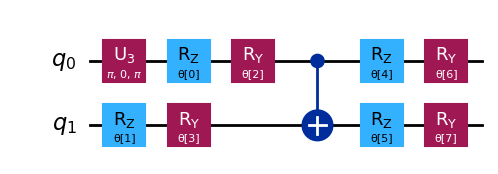

In [5]:
from qiskit.circuit.library import TwoLocal

reference_circuit = QuantumCircuit(2)
reference_circuit.x(0)

variational_form = TwoLocal(
    2,
    rotation_blocks=["rz", "ry"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=1,
)
ansatz = reference_circuit.compose(variational_form)

ansatz.decompose().draw('mpl')

## Step 2: Optimize the circuit for execution on hardware

In this step, the circuit is optimized for a target hardware device.

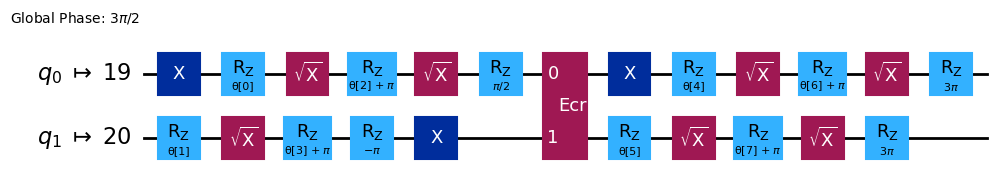

In [15]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeQuebec

# Specify backend to use
#backend = service.backend('ibm_quebec')
backend = FakeQuebec()
target = backend.target

# Create PassManager for transpiling
pm = generate_preset_pass_manager(target=target, optimization_level=3)
isa_ansatz = pm.run(ansatz)
isa_observable = H.apply_layout(isa_ansatz.layout)
isa_ansatz.draw(style='iqp', idle_wires=False)

## Step 3: Execute on quantum computer

The energy can also be viewed as a "cost". In this case, we're looking for the minimum eigenvalue.

Here is a definition of the cost function. It uses the `Estimator` primitive to compute an expectation value using the Hamiltonian expression above as the observable given a parameterized circuit that prepares a trial state or "ansatz".

In [12]:
def cost_func(params, ansatz, hamiltonian, estimator, callback=None):
    """Return estimate of cost from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: cost estimate
    """
    pub = (ansatz, hamiltonian, params)
    cost = estimator.run([pub]).result()[0].data.evs

    if callback is not None:
        callback(cost)

    return cost

Adding a callback function to track progress of the minimization process is helpful

In [13]:
class Callback:

    def __init__(self):
        self.iteration = 0

    def __call__(self, cost):
        self.iteration += 1
        print('\r', "Iteration:", self.iteration, ", cost:", cost, end='')

Initial values for the circuit parameters

In [14]:
import numpy as np

x0 = 2 * np.pi * np.random.random(ansatz.num_parameters)
x0

array([5.84756274, 6.21413343, 1.63301644, 5.21736368, 5.68625431,
       3.42356077, 5.12201578, 2.26221328])

Now, set up a `Session` and minimize the cost function using `scipy.optimize`. The `minimize` function will iteratively vary the parameters of the ansatz circuit according to the expectation value returned by the `Estimator` and attempt to adjust those parameters to find the lowest possible cost.

In [17]:
from scipy.optimize import minimize

callback = Callback()

with Session(backend=backend) as session:
    print("Session ID:", session.session_id)
    estimator = Estimator(mode=session)
    result = minimize(cost_func, x0, args=(isa_ansatz, isa_observable, estimator, callback), method="COBYLA", options={"maxiter": 100})

print(result)

Session ID: None
 Iteration: 91 , cost: -5.20458984375 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -5.20458984375
       x: [ 4.038e+00  7.531e+00  1.546e+00  6.272e+00  5.303e+00
            4.038e+00  3.727e+00  3.820e+00]
    nfev: 91
   maxcv: 0.0


## Step 4: Post-process results

In [18]:
print(f'Estimated ground state energy: {result["fun"]}')

Estimated ground state energy: -5.20458984375


In [19]:
from qiskit.version import get_version_info as get_qiskit_version_info
from qiskit_ibm_runtime.version import get_version_info as get_runtime_version_info

print(f"Qiskit version: {get_qiskit_version_info()}")
print(f"Qiskit Runtime version: {get_runtime_version_info()}")

Qiskit version: 1.2.4
Qiskit Runtime version: 0.30.0
